## Stochastic environment (First requirement)

In [33]:
import numpy as np
import matplotlib.pyplot as plt 
import Configuration as config
from scipy import stats
from scipy import optimize
from tqdm.notebook import tqdm

!python ./Configuration.py      # to have configuration values updated

### Stochastic environment 
The stochastic environment takes as "input" the action of the agent which corresponds to the bid. Then it simulates the distribution from which the other bids are sampled and the probability conversion (prob. of buying given a price -> demand curve normalized). Eventually, it outputs the reward associated with  

In [34]:
class pricing_stochastic_env:
    def __init__(self, conversion_probability, cost=0.2):
        #self.rewards 
        self.cost = cost
        self.conversion_probability = conversion_probability

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost) * d_t      # the reward is equal to the profit given by (price-cost)*expected demand (sampled)
        return d_t, r_t


    

In [35]:
class bidding_stochastic_env:
    def __init__(self, B, T, lambdas, n_advertisers):
        self.B = B
        self.T = T      
        #self.rho = B/T
        self.lambdas = lambdas
        self.n_slots = len(self.lambdas)
        self.ctrs = np.ones(n_advertisers+1)    # for simplicity we keep them all equal to 1, the +1 is for including myself

    def get_winners(self, bids):
        adv_values = self.ctrs*bids                 # computing values = q*b
        adv_ranking = np.argsort(adv_values)        # array with the index of adv_values sorted in increasing order
        winners = adv_ranking[-self.n_slots:]       # taking the last n_slots indexes, i.e. the indexes of the highest values
        winners_values = adv_values[winners]
        return winners, winners_values
        
    def get_payments_per_click(self, values, winners):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])        # second-price auctions (truthful)
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)

    def round(self, bids):
        # bids contains all bids, including mine which is stored in the first position
        winners, values = self.get_winners(bids)        # winners are the indexes of the highest values in the array
        payments_per_click = self.get_payments_per_click(values, winners)
        return winners, payments_per_click


### Pricing algorithm
Build a pricing strategy using the continuous set of prices $p \in [0,1]$ and Gaussian Processes

In [36]:
# taken from lab session 3
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [37]:
# taken from lab session 3 as well
class pricing_agent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))      # from PAPER LINKED IGP-UCB ALGORITHM
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

### Bidding algorithms
Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- a primal-dual algorithm for truthful auctions
- a UCB-like algorithm

Second-price auctions so we are asked to implement truthful auctions -> since we want to consider the multi-slot case, we must use VCG auctions. The generic algorithm for truthful auctions is the following:
1. the bidder chooses $b_t \in [0,1]$
2. the bidder utility is $f_t(b_t) = (v - p_a)\mathbf{1}[\text{when ad in some displayed slot}]$
3. the bidder incurs a cost $c_t(b_t) = p_a\mathbf{1}[\text{when ad in some displayed slot}]$
4. the budget is decreased by $c_t(b_t)$
5. if the budget is smaller than 1 the bidder interaction stops

Where $p_a = \frac{(Y_a - X_a)}{\lambda_{s(a)}q_a}$ from VCG auctions.

The UCB-like algorithm for bidding uses:
- as arms the discretized set of possible biddings 
- as reward the utility $f_t(b_t)$


In [38]:
class primal_dual_agent:
    def __init__(self, B, T, eta) -> None:
        pass
    
    def action():
        # choose price to bid
        pass
    
    def update():
        pass

This can be implemented following the algorithm in the slide 18 from slide package 8.

In [39]:
class UCB_agent:
    def __init__(self, B, T, prices, n_advertisers, n_users, eta=0.1) -> None:
        self.B = B          # budget
        self.T = T          # number of rounds
        self.arms = prices  # arms of the UCB algorithm -> discretization of the prices
        self.eta = eta      # learning rate
        self.N_pulls = np.zeros(len(self.arms))     # number of pulls for each arm
        self.t = 0          # time step
        self.a_t = None     # arm played at time t
        self.n_advertisers = n_advertisers          # number of advertisers (excluded the agent)
        self.rho = B/T      # budget per round
        self.n_users = n_users  
        self.my_valuation = 0.8         # CHOSEN RANDOMLY, CHECK
        self.budget_depleted = False
        self.average_rewards = np.zeros(len(self.arms))    # average rewards for each arm
    def action(self):
        # choose price to bid   
        if self.B <= 1:
            if not self.budget_depleted:
                print('Budget depleted at round',self.t)
                self.budget_depleted = True
            self.a_t = 0        # cannot bid because the budget is depleted
        elif self.t < len(self.arms):     # have not pulled all arms yet
            self.a_t = self.arms[self.t]
        else:
            # arm choosen by UCB algorithm
            ucbs = self.average_rewards + np.sqrt(2*np.log(self.T)/self.N_pulls)
            #print(f'UCBs: {ucbs} - argmax: {np.argmax(ucbs)}')
            self.a_t = self.arms[np.argmax(ucbs)]
        #print(f'Arm chosen: {self.a_t} with index {np.where(self.arms==self.a_t)[0][0]}')
        return self.a_t
    
    def update(self, f,c):
        print(np.where(self.arms==self.a_t))
        arm_played_index = np.where(self.arms==self.a_t)[0][0]      # bad code to get the index of an element, no index() bc it is a numpy array
        self.N_pulls[arm_played_index] += 1    # we update the number of pulls for the arm played
        self.average_rewards[arm_played_index] += (f - self.average_rewards[arm_played_index])/self.N_pulls[arm_played_index]
        self.t += 1     # incresing time step
        self.B -= c     # updating the budget
        print(f'Budget updated: {self.B}')

### General framework to be modeled

In [40]:
# importing parameters
import importlib
importlib.reload(config)
ITERATIONS = config.ITERATIONS
AUCTIONS = config.AUCTIONS
N_USERS = config.N_USERS
N_ADVERTISERS = config.N_ADVERTISERS    # number of companies that compete for slot auctions, including myself
NUMBER_OF_ARMS = config.NUMBER_OF_ARMS    # needed for the UCB algorithm
PRICES = config.PRICES    # actual arms of the ucb algorithm
BUDGET = config.BUDGET
NUMBER_OF_SLOTS = config.NUMBER_OF_SLOTS
LAMBDAS = np.flip(config.LAMBDAS)



conversion_probability = lambda p: 1-p/20
pricing_agent = pricing_agent(ITERATIONS, NUMBER_OF_ARMS)
bidding_agent = UCB_agent(BUDGET, ITERATIONS, PRICES, N_ADVERTISERS,N_USERS)


pse = pricing_stochastic_env(conversion_probability, cost=0.2)      # fix this!
bse = bidding_stochastic_env(B=BUDGET, T=ITERATIONS, lambdas=LAMBDAS, n_advertisers=N_ADVERTISERS)

my_valuation = 0.8      # randomly chosen
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
my_prices = np.array([])
total_wins = 0


for round in tqdm(range(ITERATIONS)):
    p_t = pricing_agent.pull_arm()    # pricing agent choose a price p for the product
    my_prices = np.append(my_prices, p_t)
    for auction in range(AUCTIONS):
        my_bid = bidding_agent.action()    # bidding agent decides how much to bid 
        other_bids = np.random.uniform(0, 1, size = (N_ADVERTISERS)) # size = (N_ADVERTISERS, N_USERS) 
        all_bids = np.append(my_bid, other_bids)    # all bids, including mine in first position
        winners, payments_per_click = bse.round(bids=all_bids)    # somebody wins the auction
        print(f"payments_per_click: {payments_per_click}")
        my_win = 0 if 0 not in winners else 1       # boolean value which tells if my ad is shown in a slot
        #print(f'Winners: {winners}')
        if my_win:
            my_index = np.where(winners==0)[0][0]    # index of the slot where my ad is shown
            f_t, c_t = (my_valuation-payments_per_click[my_index])*my_win, payments_per_click[my_index]*my_win      # could remove my_win
        else:
            f_t, c_t = 0, 0
        print(f'Round {round} - Auction {auction} - My bid: {my_bid} - My win: {my_win} - My payment: {c_t} - My utility: {f_t}')
        bidding_agent.update(f_t, c_t)
        d_t, r_t = pse.round(p_t, n_t=N_USERS)
        pricing_agent.update(r_t/N_USERS)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins+=my_win
        

  0%|          | 0/100 [00:00<?, ?it/s]

payments_per_click: [0.   0.01 0.02 0.03 0.08 0.15 0.22 0.3  0.43 0.61]
Round 0 - Auction 0 - My bid: 0.0 - My win: 0 - My payment: 0 - My utility: 0
(array([0]),)
Budget updated: 1000
payments_per_click: [0.   0.01 0.02 0.06 0.1  0.16 0.26 0.37 0.48 0.6 ]
Round 0 - Auction 1 - My bid: 0.1111111111111111 - My win: 1 - My payment: 0.0 - My utility: 0.8
(array([1]),)
Budget updated: 1000.0
payments_per_click: [0.   0.02 0.04 0.07 0.1  0.14 0.21 0.32 0.42 0.61]
Round 0 - Auction 2 - My bid: 0.2222222222222222 - My win: 1 - My payment: 0.02 - My utility: 0.78
(array([2]),)
Budget updated: 999.98
payments_per_click: [0.   0.02 0.04 0.07 0.11 0.14 0.2  0.31 0.46 0.6 ]
Round 0 - Auction 3 - My bid: 0.3333333333333333 - My win: 1 - My payment: 0.11 - My utility: 0.6900000000000001
(array([3]),)
Budget updated: 999.87
payments_per_click: [0.   0.   0.02 0.05 0.1  0.15 0.21 0.29 0.4  0.57]
Round 0 - Auction 4 - My bid: 0.4444444444444444 - My win: 1 - My payment: 0.1 - My utility: 0.700000000000

KeyboardInterrupt: 

In [ ]:
# stop_at paramter is a float in [0,1] which tells the percentage of the total iterations to plot 
def plot_stats(utilities_hist, bids_hist, payments_hist, prices_hist, stop_at=1):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    axs[0].plot(utilities_hist[:int(len(utilities_hist)*stop_at)])
    axs[0].set_title('Utilities')
    axs[1].plot(bids_hist[:int(len(bids_hist)*stop_at)])
    axs[1].set_title('My Bids')
    axs[2].plot(payments_hist[:int(len(payments_hist)*stop_at)])
    axs[2].set_title('My Payments')
    axs[3].plot(prices_hist[:int(len(prices_hist)*stop_at)])
    axs[3].set_title('My Prices')

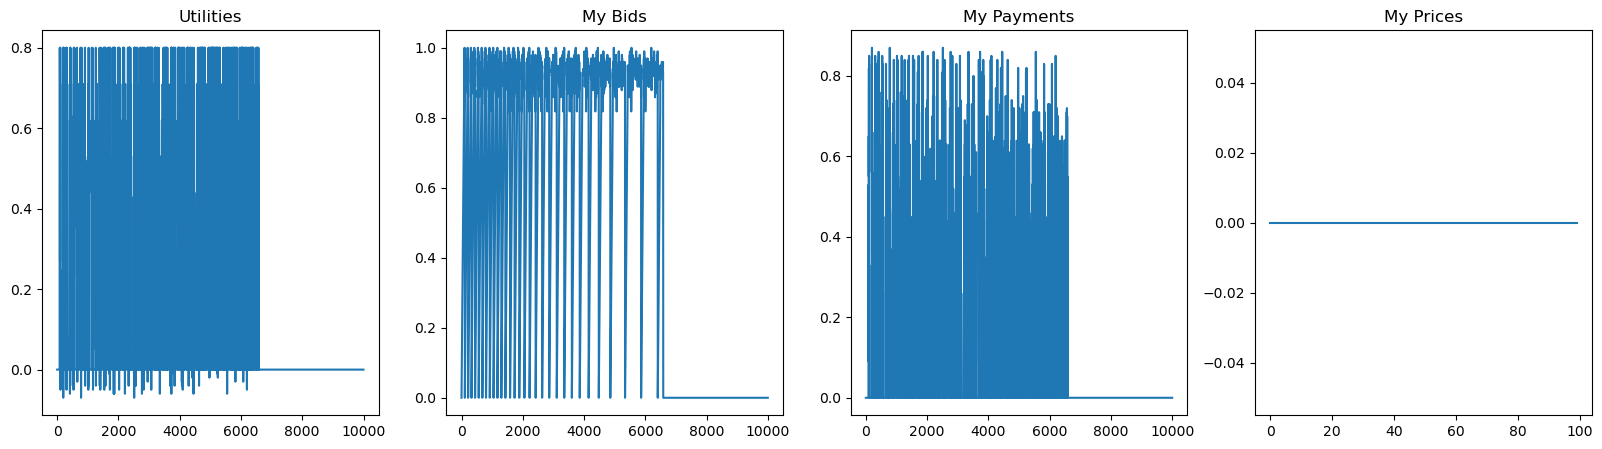

In [ ]:
plot_stats(utilities, my_bids, my_payments, my_prices) #, stop_at=0.02

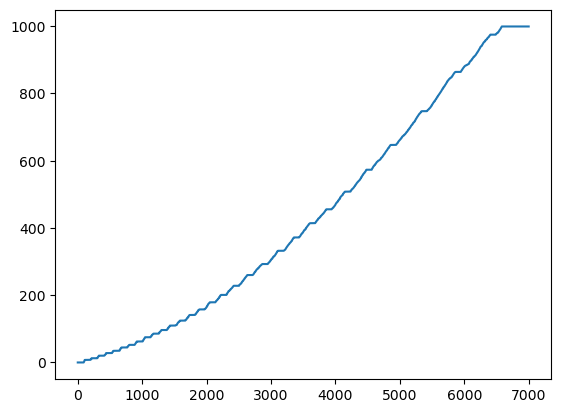

In [ ]:
plt.plot(np.cumsum(my_payments[:7000]))

In [ ]:
total_wins

3199